In [ ]:
"""Esta vez trabajaremos con el dataset llamado "The Movies Dataset" disponible en Kaggle a traves de
 https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv primero lo 
 limpiaremos y agruparemos segun la informacion que sea de nuestro interes para responder a nuestras
 preguntas planteadas."""


In [1]:
import pandas as pd
import os
import ast # Necesario para leer el texto de la colección
#(Idea dada por gemini al consultar como extraer el nombre del JSON anidado)

try:
    # Carga el CSV (low_memory=False es importante para este archivo)
    df = pd.read_csv(os.path.join("data_claudio","movies_metadata.csv"), low_memory=False)
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo 'movies_metadata.csv'.")
    exit()
def extraer_nombre_saga(valor_celda):
    try:
        datos_coleccion = ast.literal_eval(str(valor_celda))
        if isinstance(datos_coleccion, dict) and 'name' in datos_coleccion:
            return datos_coleccion['name'] # Devolvemos solo el nombre
    except:
        pass # Si falla, devuelve None
    return 
print("Archivo cargado")
df['nombre_saga'] = df['belongs_to_collection'].apply(extraer_nombre_saga) # Sacamos el nombre de la saga del JSON
df = df.dropna(subset=['nombre_saga']) #Limpiamos que no hayan quedado datos nulos
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce') #Convertimos a datetime por comodidad y para el sort posterior
df_ordenado = df.sort_values(by=['belongs_to_collection', 'release_date'],na_position='last')
# La columna "belongs_to_collection"  esta en formato JSON y nos indica si la pelicula pertenece a una collecion de peliculas
# Esta columna sera muy importante debido a que queremos comparar peliculas que sean parte de una misma coleccion
columnas_de_interes = ['nombre_saga','title','release_date','vote_average','vote_count']
df_final = df_ordenado[columnas_de_interes]
df_final = df_final.dropna(subset=columnas_de_interes) #Limpieza
df_final["vote_count"] = df_final["vote_count"].astype(int) #Transformacion
df_final.info()

#Dropeamos todas aquellas entradas que posean datos nulos en nuestras columnas de interes, ademas eliminamos aquellas peliculas que no pertenezcan a una coleccion ya que nuestro proyecto no va orientada hacia ellas


Archivo cargado
<class 'pandas.core.frame.DataFrame'>
Index: 4488 entries, 256 to 26186
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   nombre_saga   4488 non-null   object        
 1   title         4488 non-null   object        
 2   release_date  4488 non-null   datetime64[ns]
 3   vote_average  4488 non-null   float64       
 4   vote_count    4488 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 210.4+ KB


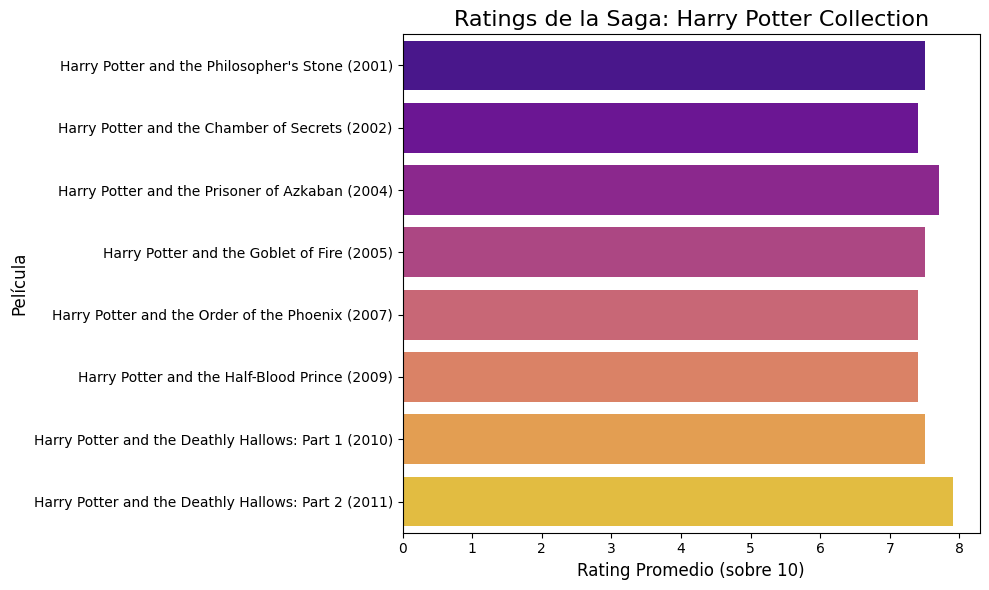

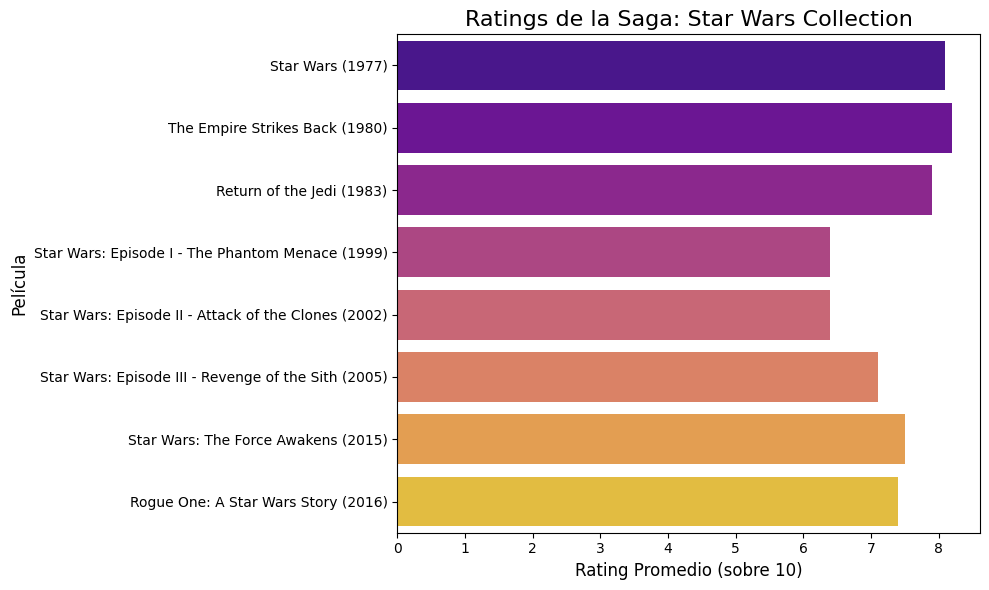

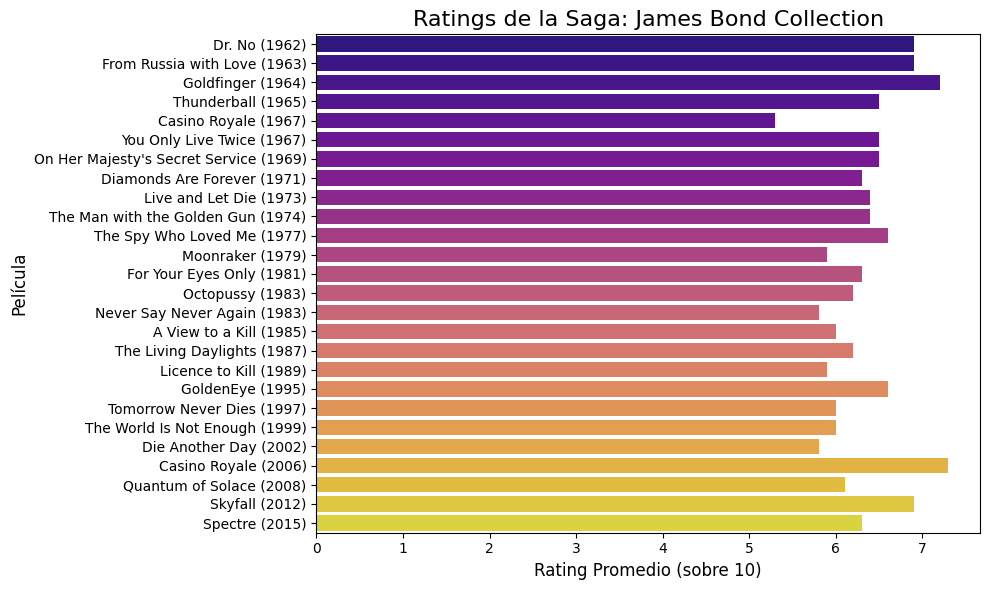

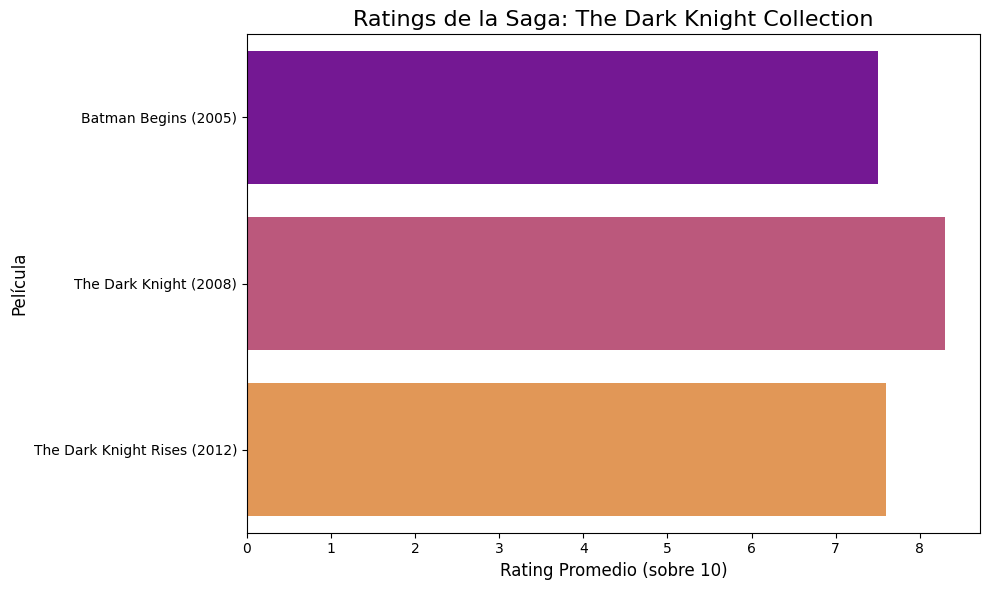

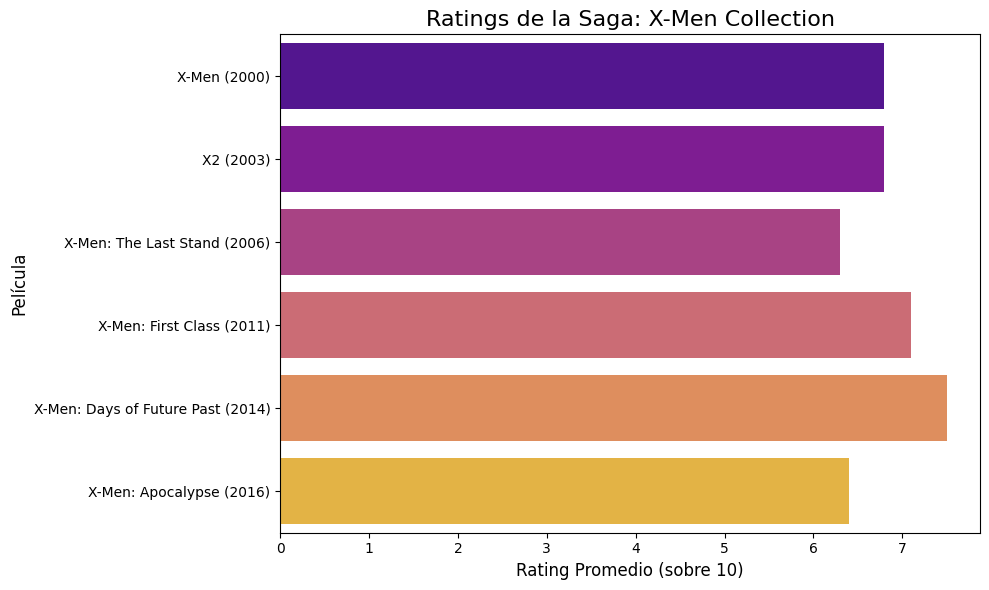

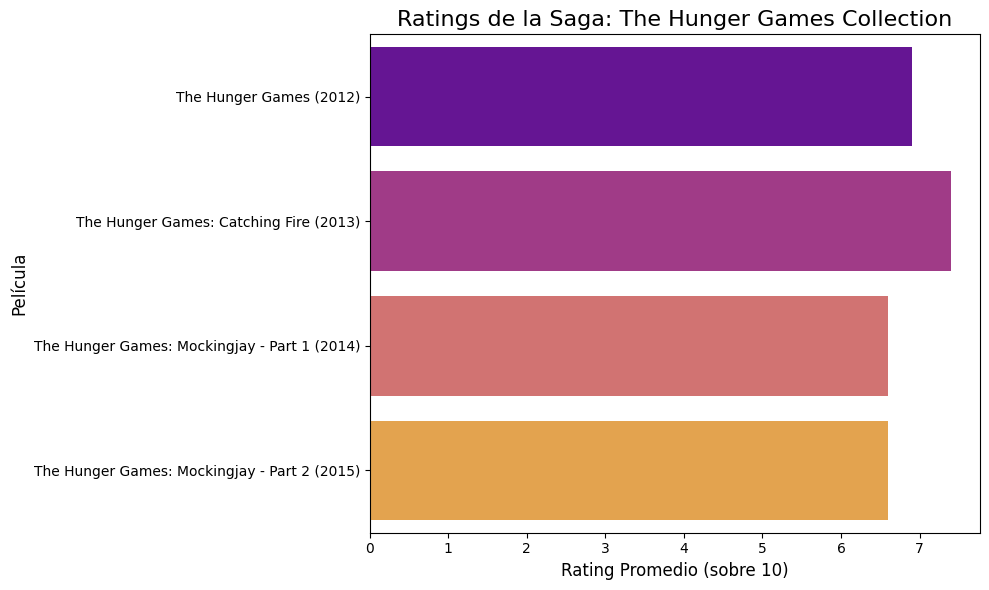

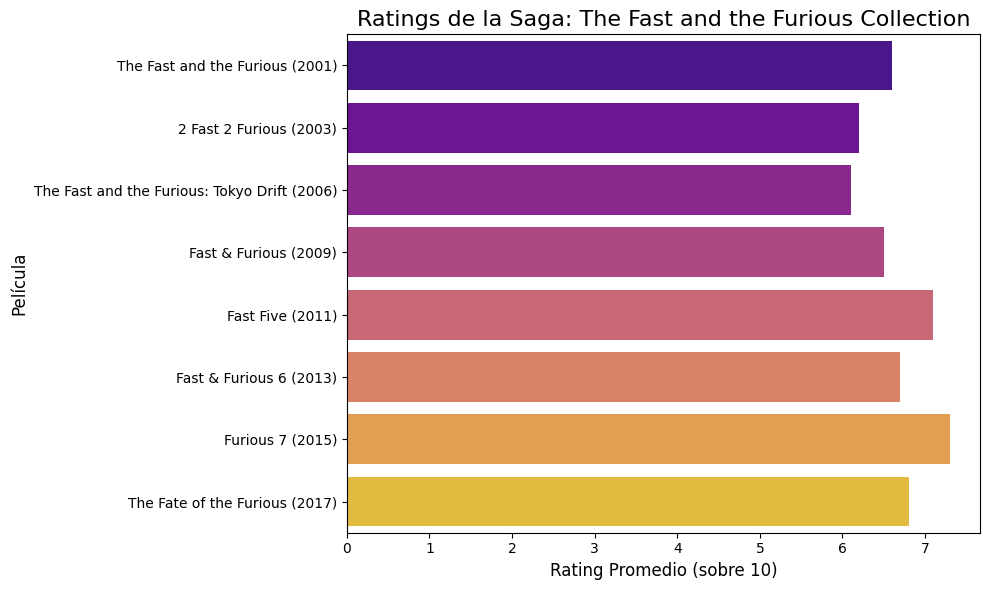

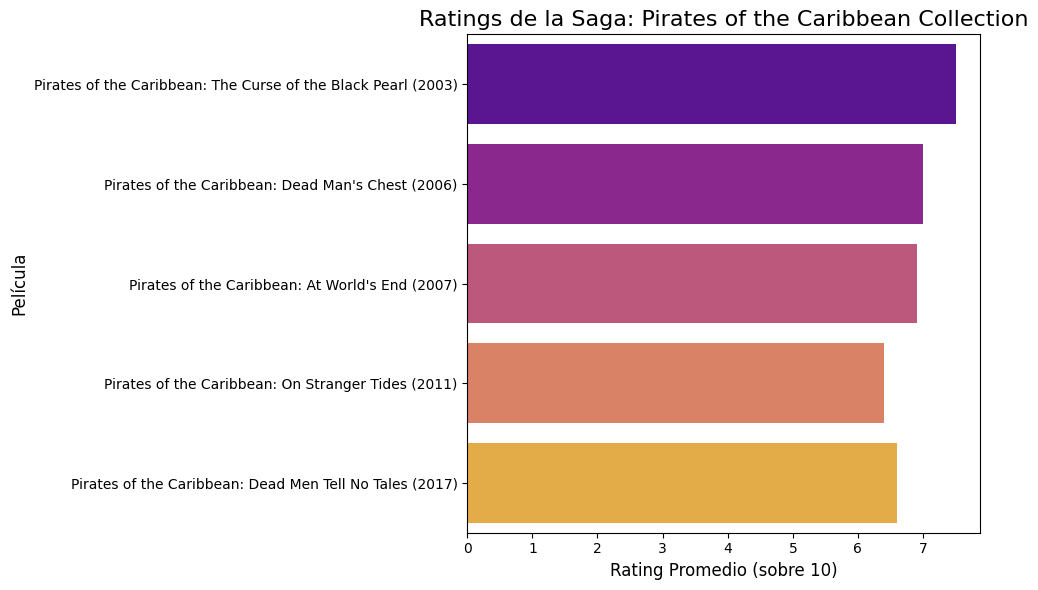

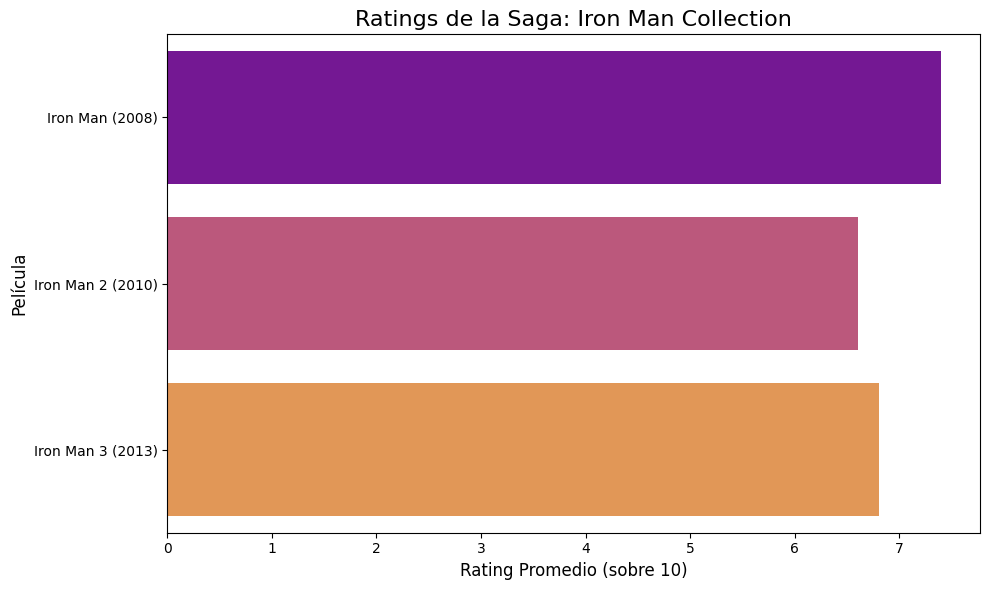

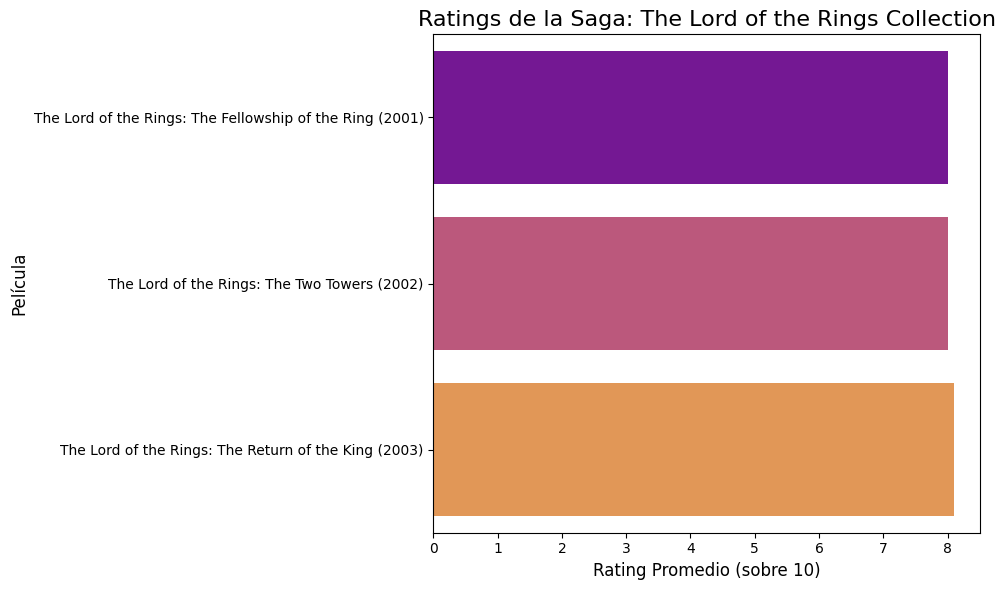

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
"""Ahora de la mano de seaborn, analizaremos distintos graficos con el objetivo de poder responder nuestras preguntas"""
len(df_final["nombre_saga"].unique()) #1695
#Debido a que son demasiadas colecciones utilizaremos las 10 peliculas mas votadas en su "vote_count" y la coleccion a la que pertenezcan seran las utilizadas
df_top10 = df_final.groupby('nombre_saga')['vote_count'].sum().sort_values(ascending=False).head(10)
sagas_top10 = []
for nombre, votos in df_top10.items():
    sagas_top10.append(nombre)
data_frames_a_graficar = []
for x in range(len(sagas_top10)):
    dataframe = df_final[df_final["nombre_saga"] == sagas_top10[x]]
    data_frames_a_graficar.append(dataframe) # VAMOS CREANDO NUESTRA LISTA CON DATAFRAMES QUE CONTENGAN TODAS LAS PELICULAS DE NUESTRO TOP 10 SAGAS CON MAS VOTOS
#GRAFICOS PARA TOP 10 PELICULAS MAS VOTADAS EN SU RATING
for element in data_frames_a_graficar:
    element = element.copy()
    nombre_saga = element['nombre_saga'].iloc[0]
    element['year'] = element['release_date'].dt.year.astype(str)
    
    element['titulo_con_fecha'] = element['title'] + " (" + element['year'] + ")"
    plt.figure(figsize=(10, 6)) 
    sns.barplot(
        x='vote_average',   
        y='titulo_con_fecha',          
        data=element,
        palette='plasma',
        hue='titulo_con_fecha',
        legend=False   
    )
    
    plt.title(f"Ratings de la Saga: {nombre_saga}", fontsize=16)
    plt.xlabel("Rating Promedio (sobre 10)", fontsize=12)
    plt.ylabel("Película", fontsize=12)
    plt.tight_layout()
    
    plt.show()




In [ ]:
"""Finalmente observamos que los rating de cada pelicula que conforma una coleccion no son muy distintos entre ellos.
Una razon seria su gran popularidad la cual se han ganado debido a lo buenas y aclamadas peliculas que son.
Si bien se observan en algunas colecciones patrones de decaimiento o aumento en los rating, estos no son una "Norma" general que aplique a todas y por ende no son representativos a nuestro parecer.
Ahora probemos con las 10 peliculas con mayor varianza en sus rating """

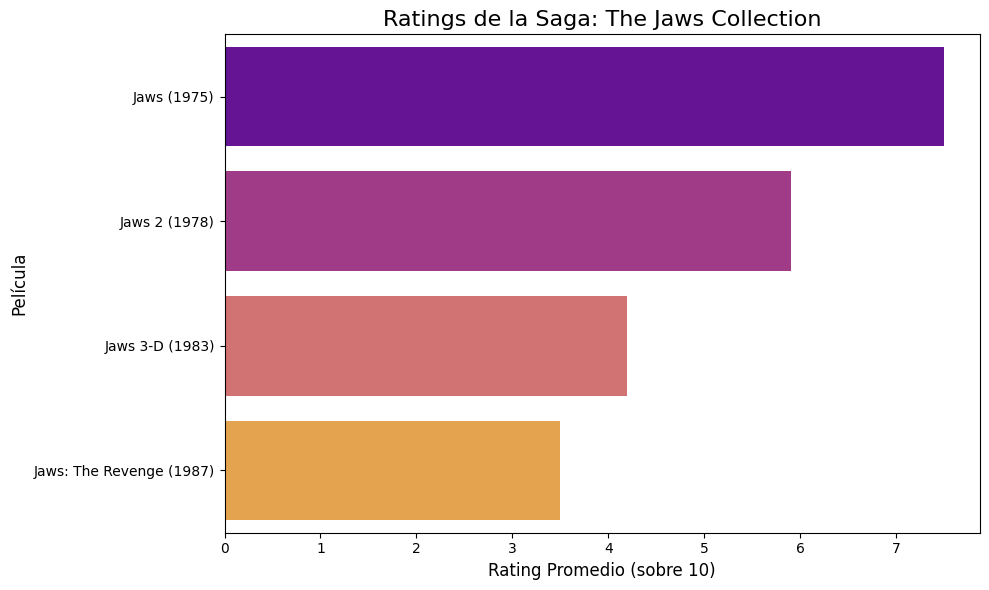

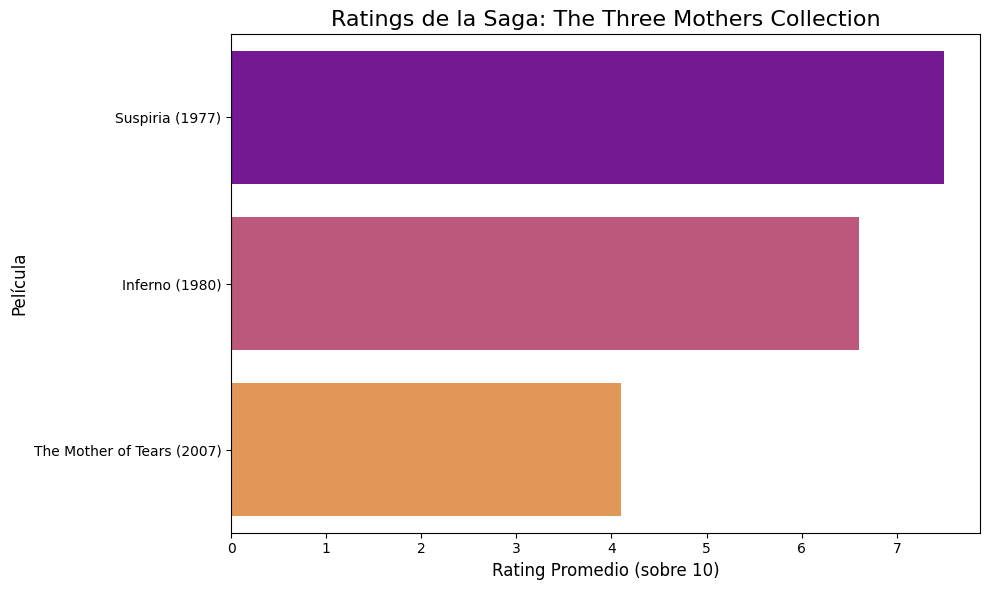

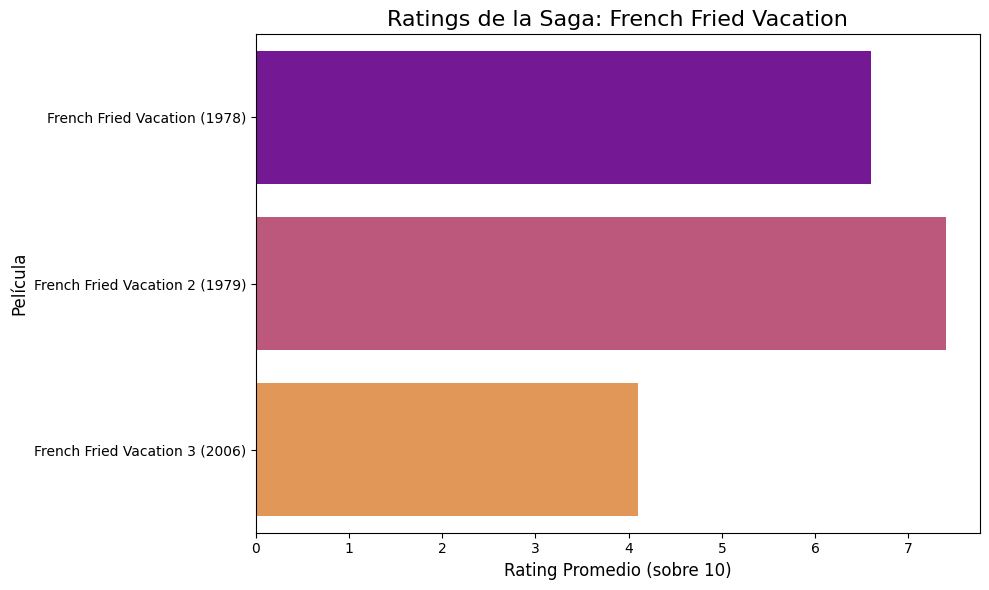

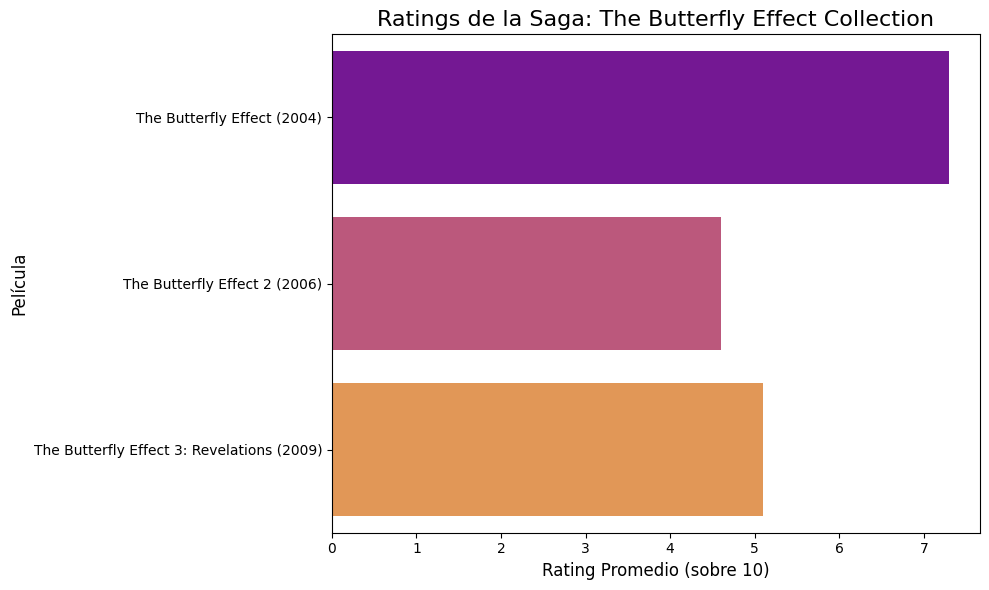

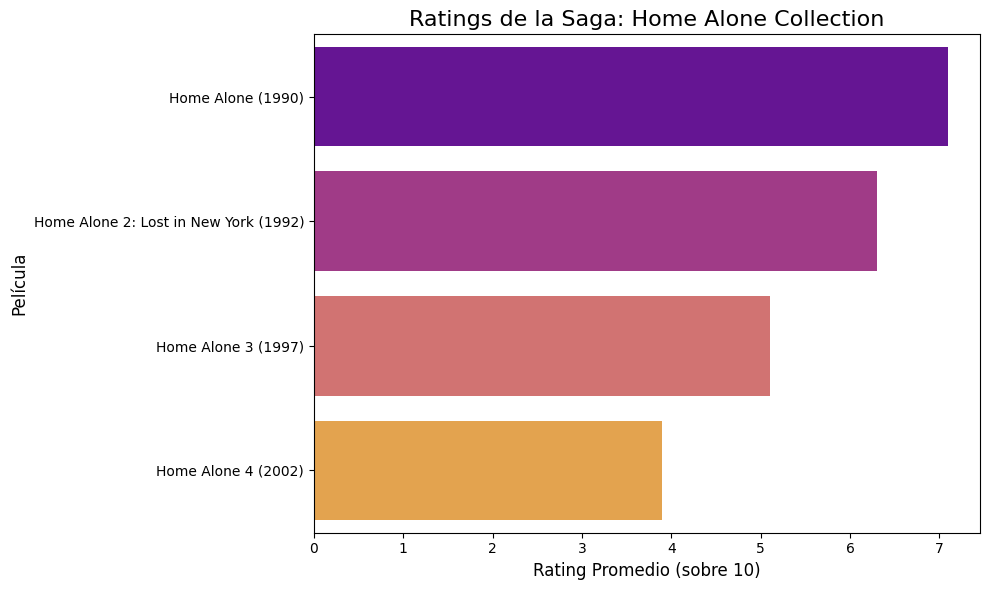

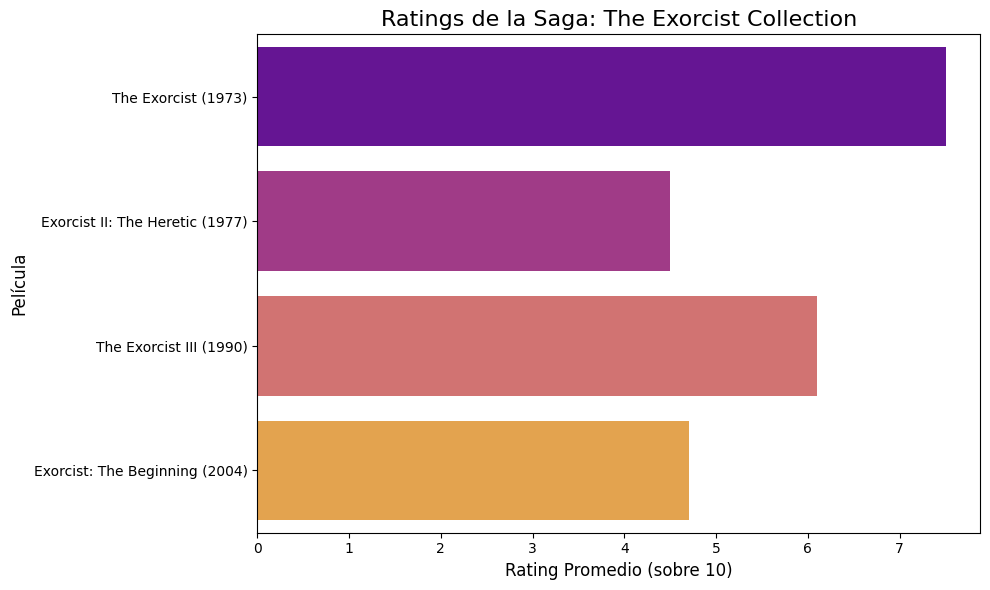

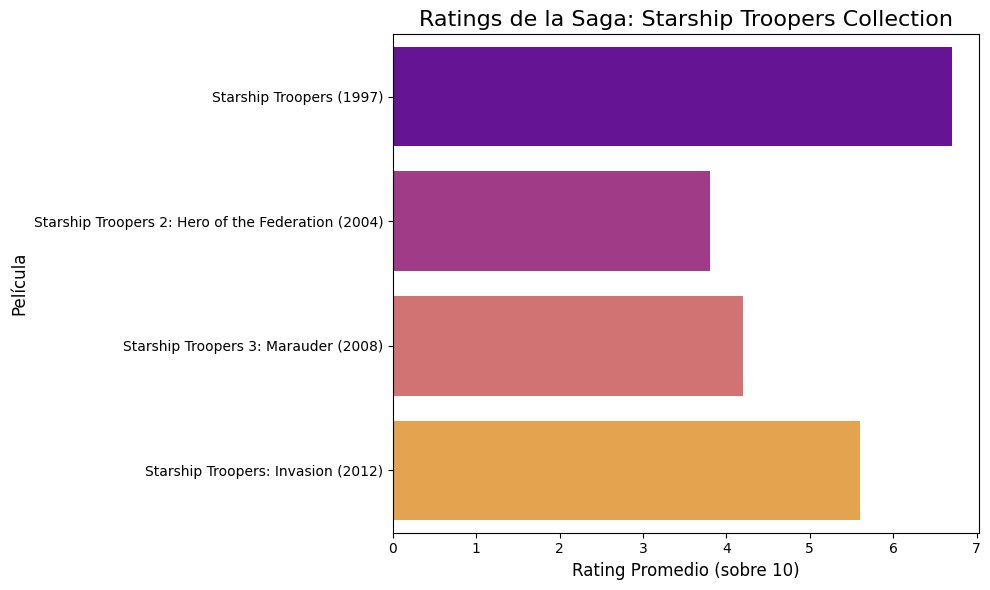

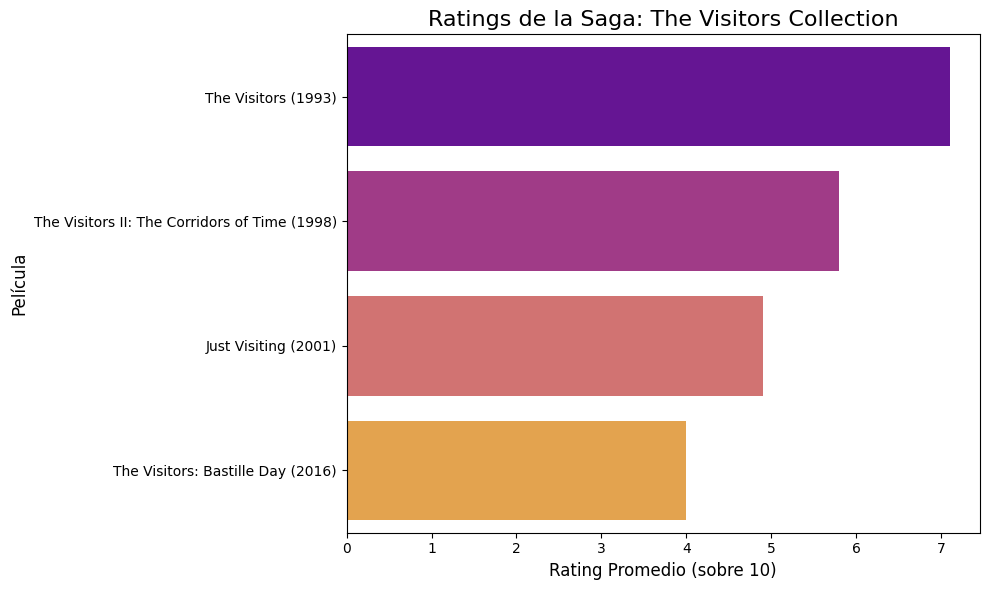

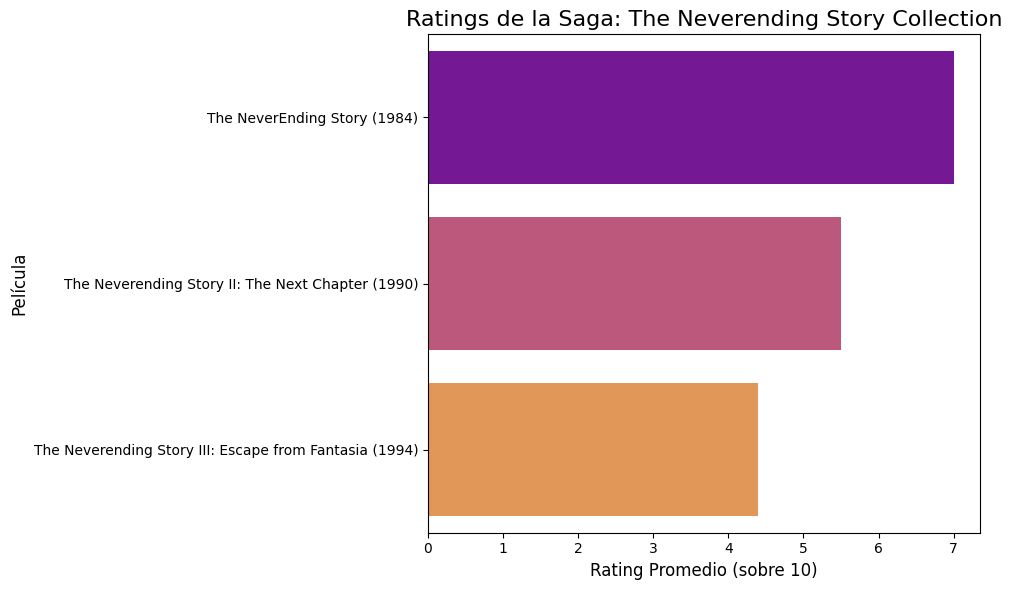

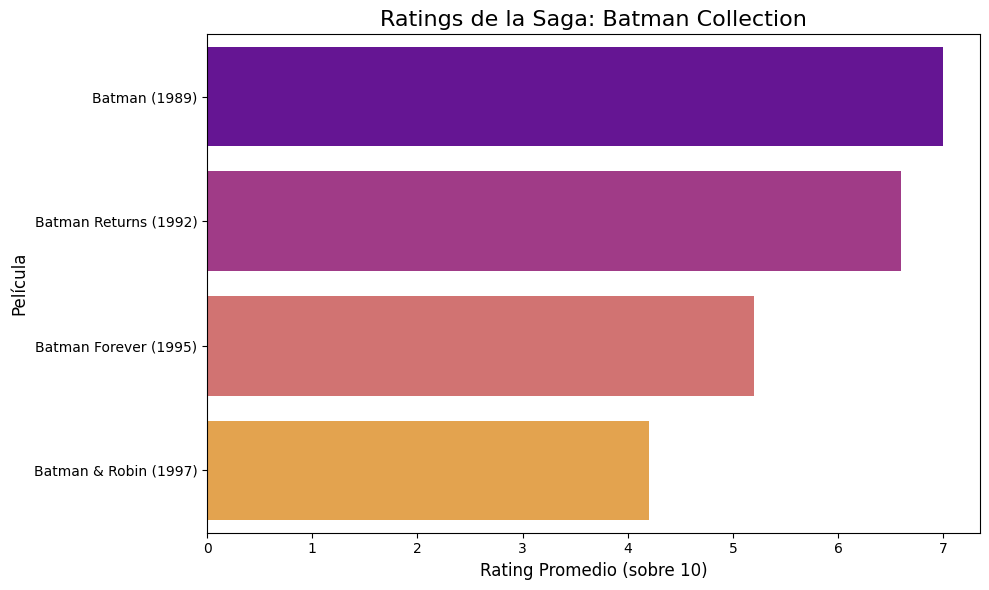

In [5]:
#GRAFICO PARA LAS 10 PELICULAS CON MAS VARIANZA
df_final = df_final[df_final["vote_count"] > 100] #Filtramos aquellas peliculas que en sus votos considere la opinion de al menos 100 personas distintas
df_filtrado = df_final.groupby('nombre_saga').filter(lambda grupo: len(grupo) >= 3)
desviacion_sagas = df_filtrado.groupby('nombre_saga')['vote_average'].std() #AGRUPAMOS SEGUN VARIANZA
nombres_con_mas_varianza = desviacion_sagas.sort_values(ascending=False).head(10) # HACEMOS SORT PARA SACAR LAS 10 COLECCIONES CON MAS VARIANZA
varianza = []
for nombre, votos in nombres_con_mas_varianza.items():
    varianza.append(nombre)
data_frames_a_graficar = []
for x in range(len(varianza)):
    dataframe = df_filtrado[df_filtrado["nombre_saga"] == varianza[x]]
    data_frames_a_graficar.append(dataframe) # VAMOS CREANDO NUESTRA LISTA CON DATAFRAMES QUE CONTENGAN TODAS LAS PELICULAS DE NUESTRO TOP 10 SAGAS CON MAS VARIANZA
#GRAFICOS PARA TOP 10 PELICULAS MAS VOTADAS EN SU RATING
for element in data_frames_a_graficar:
    element = element.copy()
    nombre_saga = element['nombre_saga'].iloc[0] #NOMBRE
    element['year'] = element['release_date'].dt.year.astype(str) # DE DATETIME SACAMOS EL AÑO YA QUE ES MAS REPRESENTATIVO
    
    element['titulo_con_fecha'] = element['title'] + " (" + element['year'] + ")" #PELICULA Y SU AÑO DE PUBLICACION
    plt.figure(figsize=(10, 6)) 
    sns.barplot(
        x='vote_average',   
        y='titulo_con_fecha',          
        data=element,
        palette='plasma',
        hue='titulo_con_fecha',
        legend=False   
    )
    
    plt.title(f"Ratings de la Saga: {nombre_saga}", fontsize=16)
    plt.xlabel("Rating Promedio (sobre 10)", fontsize=12)
    plt.ylabel("Película", fontsize=12)
    plt.tight_layout()
    
    plt.show()


In [ ]:
"""Tal como se espero, podemos observar una desviacion estandar muy significativa entre los rating de las peliculas de las colecciones filtradas,
y tambien podemos observar un patron, un patron de decrecimiento en el rating. En general todas las colecciones empiezan con una pelicula bien calificada
y mientras van sacando mas peliculas poco a poco este rating va disminuyendo a gran nivel. Tambien observemos que esto ocurre para cualquier rango de diferencia
de años entre publicacion de la pelicula (1,2,3,4 o 5 años). 
Es por esto que finalmente  descartamos la idea de que el tiempo entre año de publicacion de las peliculas de una coleccion forman parte de los factores que llevan
al fracaso de esta misma ya que se observo la misma idea en diversos rangos de tiempo. """